colab drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/images/image_train_resized.zip" -d "/content"

In [3]:
import os

# Nouveau chemin de pointage
mon_chemin = '/content/drive/My Drive/Colab Notebooks'

# Changer le répertoire de travail actuel
os.chdir(mon_chemin)

In [ ]:
# Chargement du dataframe

In [9]:
!pip install vit_keras tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [27]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from vit_keras import vit

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin

import os


In [28]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

features = ['designation_translated', 'description_translated', 'productid', 'imageid']
df = pd.read_csv('data/clean/df_train_index.csv')
data = df[features]
target = df.prdtypeindex

X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, stratify=target)

le = LabelEncoder()
le.classes_ =  np.load('data/clean/le_classes.npy', allow_pickle=True)


In [29]:
from tensorflow.keras.utils import Sequence

class MultimodalDataGenerator(Sequence):
    def __init__(self, img_data_generator, img_path, text_tokenized, labels=None, batch_size=32, target_size = (224, 224), shuffle=True):
        self.img_data_generator = img_data_generator
        self.dataframe = pd.DataFrame({'filename':img_path})#dataframe.copy()
        self.text_tokenized = text_tokenized
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:min((index + 1) * self.batch_size, len(self.dataframe))]
        batch_indexes_tensor = tf.convert_to_tensor(batch_indexes, dtype=tf.int32)

        batch_df = self.dataframe.iloc[batch_indexes]

        img_generator = self.img_data_generator.flow_from_dataframe(dataframe=batch_df, target_size=self.target_size,
                                                                    x_col="filename", y_col=None,class_mode=None,
                                                                    batch_size=len(batch_df), shuffle=False, verbose=2)

        images = np.concatenate([img_generator.next() for _ in range(len(img_generator))], axis=0)

        token_ids = tf.gather(self.text_tokenized['input_ids'], batch_indexes_tensor, axis=0)
        attention_mask = tf.gather(self.text_tokenized['attention_mask'], batch_indexes_tensor, axis=0)

        if self.labels is not None:
          labels = self.labels[batch_indexes].values
        else:
          labels = np.zeros(batch_df.shape[0])
        return [{"input_ids": token_ids, "attention_mask": attention_mask}, images], labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [45]:
path_model_txt = 'model/camembert_base_256_16_lr1.keras'
path_model_img = 'model/ViT_b16.tf'





In [50]:
from src.model import bert_classifier as bc


model_base_txt = tf.keras.models.load_model(path_model_txt)
model_base_img = tf.keras.models.load_model(path_model_img)


TypeError: Could not locate class 'TFSpecificClassifier'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'TFSpecificClassifier', 'config': {'num_labels': 27}, 'registered_name': 'TFSpecificClassifier', 'build_config': {'input_shape': {'input_ids': [None, 256], 'attention_mask': [None, 256]}}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 9.999999747378752e-06, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'SparseCategoricalCrossentropy', 'config': {'reduction': 'auto', 'name': 'sparse_categorical_crossentropy', 'from_logits': True, 'ignore_class': None, 'fn': 'sparse_categorical_crossentropy'}, 'registered_name': None}, 'metrics': [{'module': 'keras.metrics', 'class_name': 'SparseCategoricalAccuracy', 'config': {'name': 'accuracy', 'dtype': 'float32'}, 'registered_name': None}], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [32]:

# freeze des poids
for layer in model_base_txt.layers:
  layer.trainable = True
for layer in model_base_img.layers:
  layer.trainable = True

# model txt
input_ids_txt = Input(shape=(256,), dtype='int32', name='input_ids')
attention_mask_txt = Input(shape=(256,), dtype='int32', name='attention_mask')
# token_id_txt = Input(shape=(256,), dtype='int32', name='token_type_ids')
inputs_txt = {
    'attention_mask': attention_mask_txt,
    'input_ids': input_ids_txt,
    # 'token_type_ids': token_id_txt
}
transformer_layer_txt = model_base_txt(inputs_txt)
# transformer_layer_txt[0]
output_txt = transformer_layer_txt
model_txt = Model(inputs=inputs_txt, outputs=output_txt)

# model img
inputs_img = Input(shape=(224,224,3), name='inputs_img')
output_img = model_base_img(inputs_img)
model_img = Model(inputs=inputs_img, outputs=output_img)

# Concat
rakuten_inputs = [inputs_txt, inputs_img]
# model_img.output[1]
rakuten_transformer = Concatenate()([model_txt.output,model_img.output])
dense1 = Dense(128, activation='relu')(rakuten_transformer)
dropout1 = Dropout(rate=0.2)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(rate=0.2)(dense2)
rakuten_output = Dense(27, activation='softmax')(dropout2)
model_rakuten = Model(inputs=rakuten_inputs, outputs=rakuten_output)
model_rakuten.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rakuten.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 inputs_img (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 tf_specific_classifier (TF  (None, 27)                   0         ['attention_mask[0][0]',

In [33]:
tokenizer = AutoTokenizer.from_pretrained(path_model_txt+'/tokenizer')




In [34]:
X_train_tokenized = tokenizer(X_train[['designation_translated','description_translated']].apply(lambda row: ' '.join([s for s in row if isinstance(s, str)]), axis=1).tolist(), padding="max_length", truncation=True, max_length=256, return_tensors="tf")
X_train_img = X_train.apply(lambda row: '/content/image_train_resized/image_{}_product_{}_resized.jpg'.format(row.imageid, row.productid), axis=1)
X_train_img = X_train_img.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val_tokenized = tokenizer(X_val[['designation_translated','description_translated']].apply(lambda row: ' '.join([s for s in row if isinstance(s, str)]), axis=1).tolist(), padding="max_length", truncation=True, max_length=256, return_tensors="tf")
X_val_img = X_val.apply(lambda row: '/content/image_train_resized/image_{}_product_{}_resized.jpg'.format(row.imageid, row.productid), axis=1)
X_val_img=X_val_img.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)


In [26]:
X_train_img[:5]

63411    /content/image_train_resized/image_1025671439_...
53665    /content/image_train_resized/image_248001999_p...
63974    /content/image_train_resized/image_1275035489_...
30957    /content/image_train_resized/image_1319051557_...
30374    /content/image_train_resized/image_949320909_p...
dtype: object

In [35]:
params = dict(rotation_range=0, width_shift_range=0,
                          height_shift_range=0, horizontal_flip=False,
                          fill_mode='constant', cval=255)

img_generator_train = ImageDataGenerator(rescale = 1./255, samplewise_center = True, samplewise_std_normalization = True,
    rotation_range=params['rotation_range'],
    width_shift_range=params['width_shift_range'],
    height_shift_range=params['height_shift_range'],
    horizontal_flip=params['horizontal_flip'],
    fill_mode=params['fill_mode'],
    cval=params['cval'])
img_generator_val = ImageDataGenerator(rescale = 1./255, samplewise_center = True, samplewise_std_normalization = True,
    rotation_range=params['rotation_range'],
    width_shift_range=params['width_shift_range'],
    height_shift_range=params['height_shift_range'],
    horizontal_flip=params['horizontal_flip'],
    fill_mode=params['fill_mode'],
    cval=params['cval'])



In [36]:
dataset_train = MultimodalDataGenerator(img_generator_train, X_train_img, X_train_tokenized, y_train)
dataset_val = MultimodalDataGenerator(img_generator_val, X_val_img, X_val_tokenized, y_val)

In [37]:
lr = 2
save_path = 'model/multi_lr_ri_'+str(lr)

save_callback = tf.keras.callbacks.ModelCheckpoint(
    save_path,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)

optimizer = Adam(learning_rate=2*1e-5)
model_rakuten.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model_rakuten.fit(dataset_train, epochs=4, validation_data=dataset_val, callbacks=[save_callback])

Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image fil

1699/1699 [==============================] - 1206s 679ms/step - loss: 2.1779 - accuracy: 0.4488 - val_loss: 0.7862 - val_accuracy: 0.9105
Epoch 2/4
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
1699/1699 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.8750Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 v

1699/1699 [==============================] - 1149s 676ms/step - loss: 0.6798 - accuracy: 0.8750 - val_loss: 0.2269 - val_accuracy: 0.9650
Epoch 3/4
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
1699/1699 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.9428Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 v

1699/1699 [==============================] - 1151s 677ms/step - loss: 0.3096 - accuracy: 0.9428 - val_loss: 0.1044 - val_accuracy: 0.9848
Epoch 4/4
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
1699/1699 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9673Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 validated image filenames.
Found 32 v

1699/1699 [==============================] - 1151s 677ms/step - loss: 0.1817 - accuracy: 0.9673 - val_loss: 0.0609 - val_accuracy: 0.9882


In [38]:
save_path = 'model/multi_lr'+str(lr)+'_final'
model_rakuten.save(save_path)
model_rakuten.save_weights(save_path+'/tf_model.h5')
tokenizer.save_pretrained(save_path+'/tokenizer')

('model/multi_lr2_final/tokenizer/tokenizer_config.json',
 'model/multi_lr2_final/tokenizer/special_tokens_map.json',
 'model/multi_lr2_final/tokenizer/sentencepiece.bpe.model',
 'model/multi_lr2_final/tokenizer/added_tokens.json',
 'model/multi_lr2_final/tokenizer/tokenizer.json')

In [ ]:
y_pred = rakuten_model.predict(dataset_train)
y_pred_class=np.argmax(y_pred, axis=1)
y_pred_class_le = le.inverse_transform(y_pred_class)


              precision    recall  f1-score   support

           0       0.04      0.04      0.04      1994
           1       0.03      0.03      0.03      1710
           2       0.05      0.05      0.05      2530
           3       0.02      0.02      0.02       489
           4       0.06      0.06      0.06      3117
           5       0.02      0.02      0.02      1325
           6       0.06      0.06      0.06      3229
           7       0.01      0.01      0.01       517
           8       0.04      0.04      0.04      1594
           9       0.04      0.04      0.04      2074
          10       0.07      0.07      0.07      3246
          11       0.05      0.05      0.05      2753
          12       0.01      0.01      0.01       514
          13       0.05      0.06      0.06      3195
          14       0.02      0.02      0.02       527
          15       0.06      0.06      0.06      3046
          16       0.06      0.06      0.06      3055
          17       0.01    

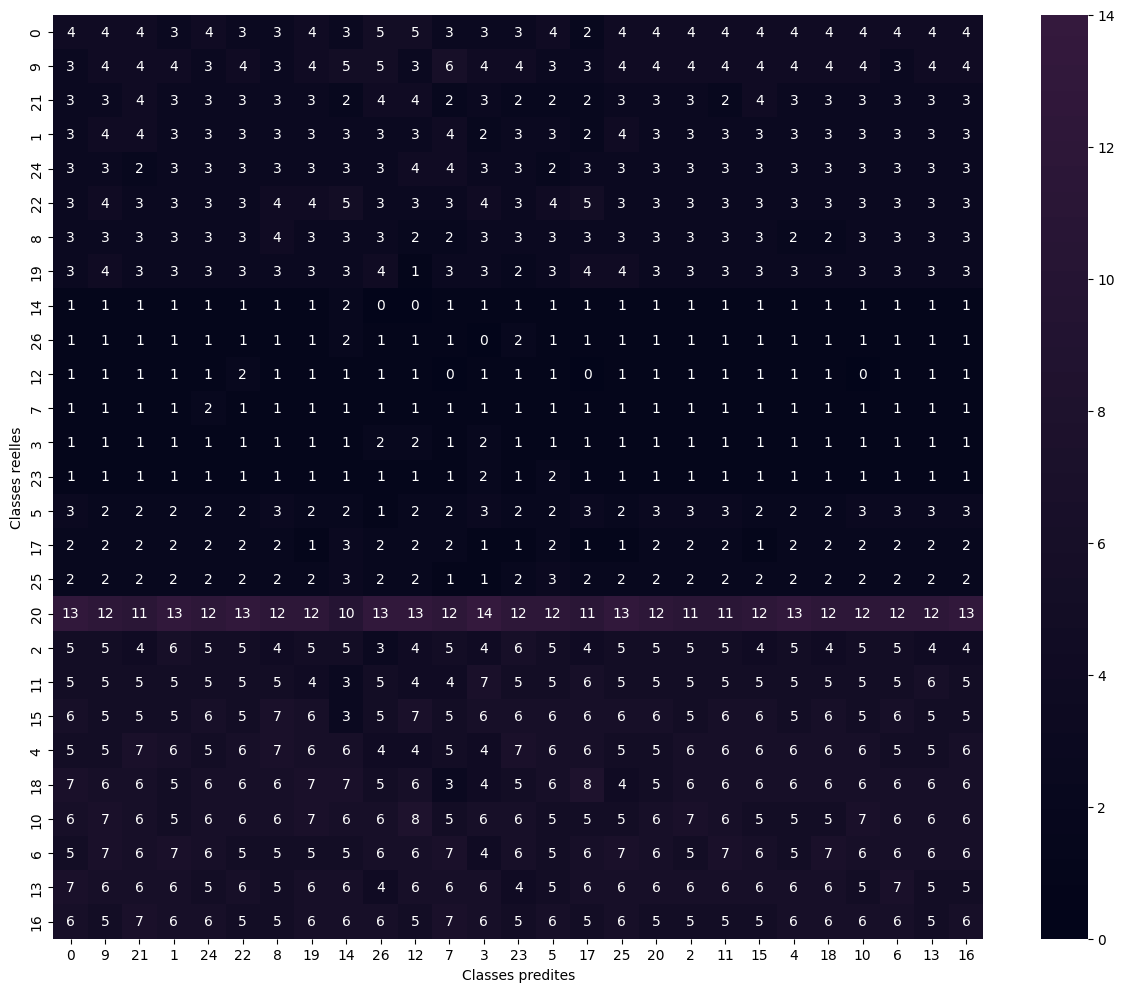

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [44]:
plot_classification_results(y_train.values, y_pred_class)

In [11]:
rakuten_model = tf.keras.models.load_model('model/multi_lr2')

In [ ]:
rakuten_model.evaluate()

In [ ]:
df_test = pd.read_csv('data/clean/df_test_index.csv')
data_test = df_test[features]
target_test = df_test.prdtypeindex

params = dict(rotation_range=0, width_shift_range=0,
                          height_shift_range=0, horizontal_flip=False,
                          fill_mode='constant', cval=255)
img_generator_test = ImageDataGenerator(rescale = 1./255, samplewise_center = True, samplewise_std_normalization = True,
    rotation_range=params['rotation_range'],
    width_shift_range=params['width_shift_range'],
    height_shift_range=params['height_shift_range'],
    horizontal_flip=params['horizontal_flip'],
    fill_mode=params['fill_mode'],
    cval=params['cval'])


X_test_txt = tokenizer(data_test[['designation_translated','description_translated']].apply(lambda row: ' '.join([s for s in row if isinstance(s, str)]), axis=1).tolist(), padding="max_length", truncation=True, max_length=256, return_tensors="tf")
X_test_img = data_test.apply(lambda row: '/content/image_train_resized/image_{}_product_{}_resized.jpg'.format(
            row.imageid, row.productid), axis=1)
X_test_img = X_test_img.reset_index(drop=True)
dataset_test = MultimodalDataGenerator(img_generator_test, X_test_img, X_test_txt)
y_pred = rakuten_model.predict(dataset_test)



In [20]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list
import pandas as pd

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))

    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index

    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()

    return plt

                                       precision    recall  f1-score   support

                 10 - Livres occasion       0.05      0.05      0.05       623
1140 - Figurines et objet pop culture       0.03      0.04      0.04       534
                1160 - Cartes de jeux       0.04      0.04      0.04       791
     1180 - Figurines et jeux de rôle       0.00      0.00      0.00       153
                1280 - Jouets enfants       0.04      0.05      0.05       974
       1281 - Jeux de société enfants       0.02      0.02      0.02       414
               1300 - Jeux techniques       0.05      0.05      0.05      1009
              1301 - Vêtements enfant       0.01      0.01      0.01       161
                         1302 - Pêche       0.03      0.03      0.03       498
                  1320 - Puériculture       0.04      0.04      0.04       648
                      1560 - Mobilier       0.06      0.05      0.05      1015
               1920 - Linge de maison       0.04   

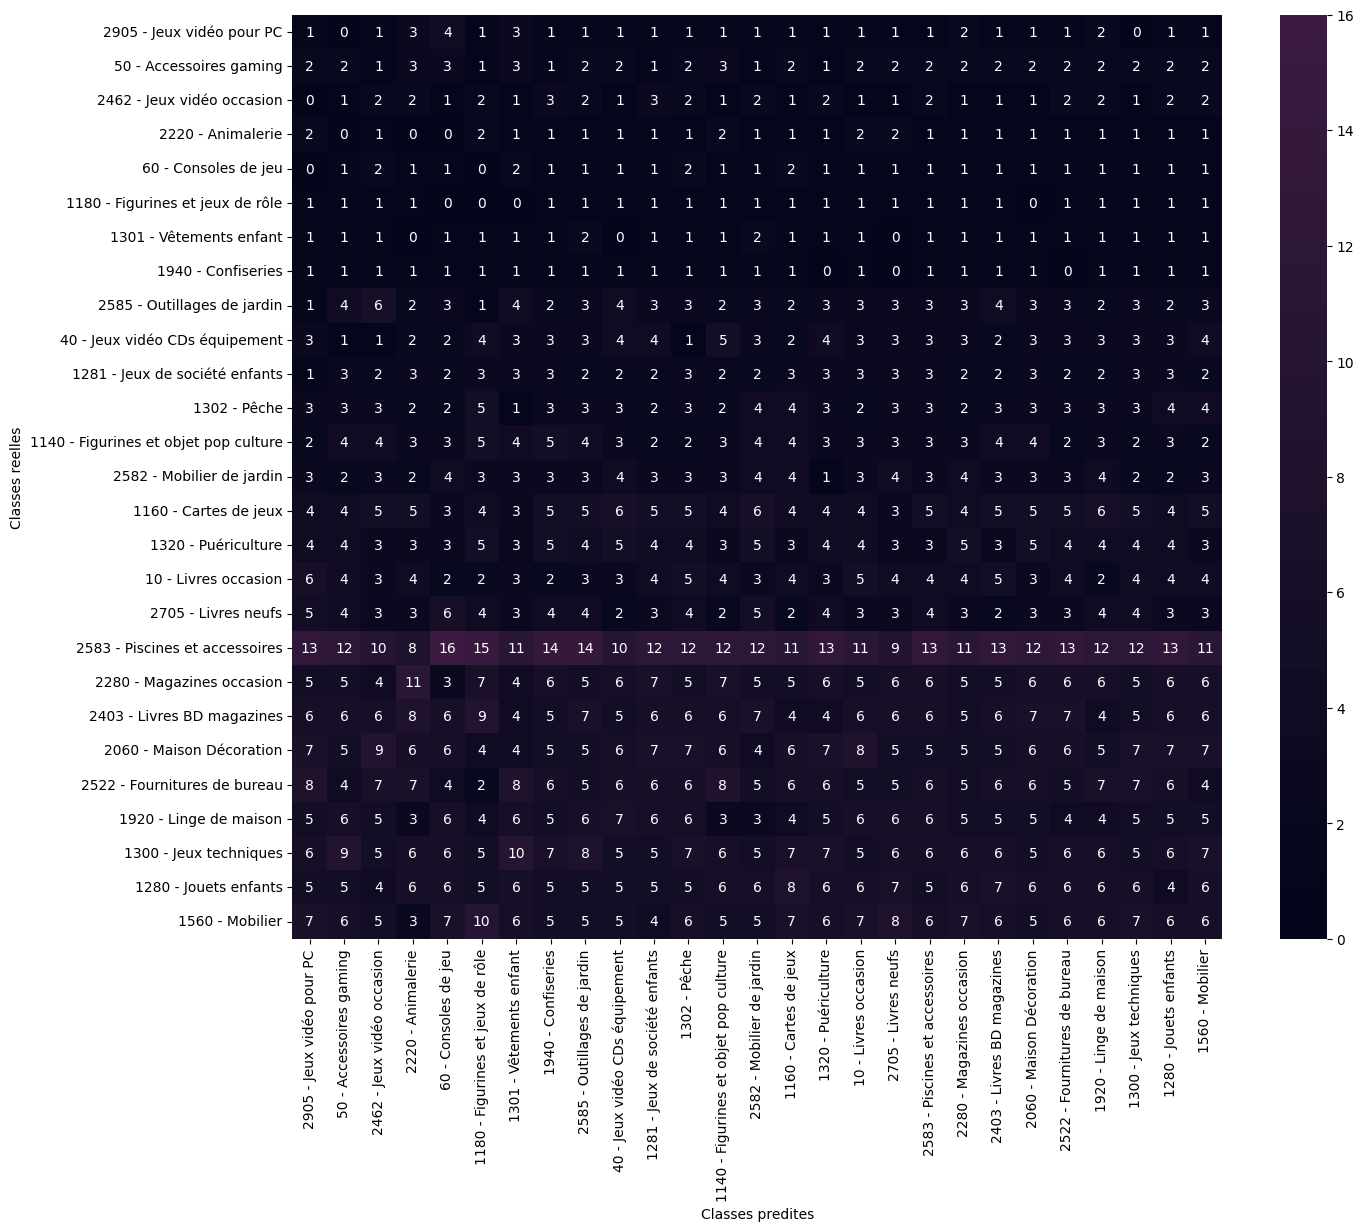

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [23]:
y_pred_class=np.argmax(y_pred, axis=1)
y_pred_class_le = le.inverse_transform(y_pred_class)
plot_classification_results(df_test['prdtypefull'].values, y_pred_class_le)